In [1]:
%%capture
pip install sentence-transformers

In [ ]:
import re
import nltk
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, util

from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ericiortega/ids705-phishing-detection/main/data/cleaning/2_cleaned_data.csv"
)
df

,sender,receiver,clean_text,urls,label
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",0,1
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,"Typo in /debian/README Hi, i've just updated f...",1,0
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,authentic viagra Mega authenticV I A G R A ...,1,1
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,"Nice talking with ya \nHey Billy, \n\nit was r...",1,1
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,or trembling; stomach cramps; trouble in sleep...,0,1
...,...,...,...,...,...
52708,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,Job: just for you. \n\n\n\nWhile we may ...,1,1
52709,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,the reply for your request for a job place [le...,1,1
52710,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,"Re: [R] Me again, about the horrible documenta...",1,0
52711,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",1,0


In [ ]:
deception_prompts = {
    "urgency": [
        "Act immediately or your account will be closed.",
        "This matter is urgent and needs your attention now.",
        "Your payment is overdue — pay within 24 hours.",
        "Respond before your account is deactivated.",
        "Immediate action is required on your account.",
    ],
    "fear": [
        "Your account has been suspended due to suspicious activity.",
        "We detected unauthorized login attempts.",
        "Security alert: your account may be compromised.",
        "Warning: your personal information is at risk.",
        "Your password has been exposed in a data breach.",
    ],
    "curiosity": [
        "Click here to uncover a hidden opportunity.",
        "You won’t believe what we found in your account.",
        "Check out this exclusive offer just for you.",
        "See what's waiting inside your inbox.",
        "Don't miss this once-in-a-lifetime chance.",
    ],
}

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode all prompts
deception_prompt_embeddings = {
    category: model.encode(prompt_list, convert_to_tensor=True)
    for category, prompt_list in deception_prompts.items()
}

# Encode all email texts
email_embeddings = model.encode(
    df["clean_text"].fillna("").tolist(), convert_to_tensor=True
)

In [10]:
# # Calculate max similarity for each deception tactic
# for category, prompt_embs in deception_prompt_embeddings.items():
#     scores = util.cos_sim(email_embeddings, prompt_embs)  # shape: [num_emails x num_prompts]
#     max_scores = torch.max(scores, dim=1).values
#     df[f"{category}_score"] = max_scores.cpu().numpy()
for category, prompt_embs in deception_prompt_embeddings.items():
    scores = util.cos_sim(email_embeddings, prompt_embs)
    max_scores = torch.max(scores, dim=1).values
    mean_scores = torch.mean(scores, dim=1)
    df[f"{category}_max"] = max_scores.cpu().numpy()
    df[f"{category}_mean"] = mean_scores.cpu().numpy()

In [ ]:
# prompt_embeddings = {
#     tactic: model.encode(text, convert_to_tensor=True)
#     for tactic, text in deception_prompts.items()
# }

In [ ]:
# email_embeddings = model.encode(df["clean_text"].fillna("").tolist(), convert_to_tensor=True)

In [ ]:
# Add max similarity scores per deception category to the dataframe
for key, emb in deception_prompt_embeddings.items():
    # Compute cosine similarities: shape [n_emails, n_prompts]
    scores = util.cos_sim(email_embeddings, emb)  # returns a 2D tensor
    max_scores = torch.max(scores, dim=1).values  # reduce to 1D
    df[f"{key}_score"] = max_scores.cpu().numpy()  # assign as 1D array
    mean_scores = torch.mean(scores, dim=1)
    df[f"{key}_mean_score"] = mean_scores.cpu().numpy()

 Add “Structural” Deception Features

In [16]:
df["num_exclamations"] = df["clean_text"].str.count("!")
df["num_uppercase_words"] = df["clean_text"].str.findall(r"\b[A-Z]{2,}\b").apply(len)

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:08:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost + Social Engineering Features Accuracy: 0.9980081570710424

📋 XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

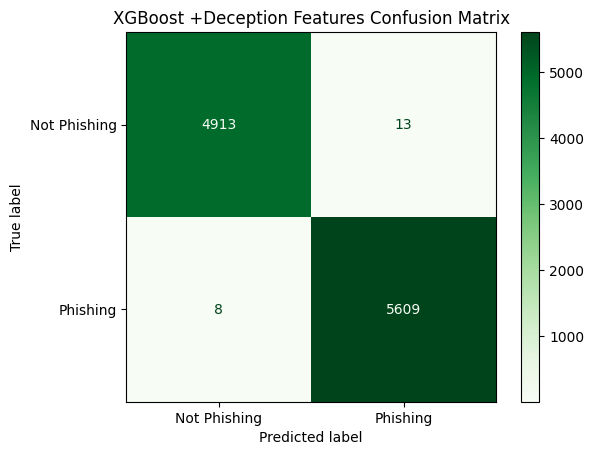

In [ ]:
# === Step 1: Preprocessing ===
for col in ["clean_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").astype(str)

# Features & labels
deception_cols = [col for col in df.columns if col.endswith("_score")]
X = df[
    [
        "clean_text",
        "sender",
        "receiver",
        "urls",
        "num_uppercase_words",
        "num_exclamations",
    ]
    + deception_cols
]
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 2: Vectorize text columns ===
tfidf_text = TfidfVectorizer(max_features=1000)
tfidf_sender = TfidfVectorizer(max_features=100)
tfidf_receiver = TfidfVectorizer(max_features=100)

X_train_text = tfidf_text.fit_transform(X_train["clean_text"])
X_test_text = tfidf_text.transform(X_test["clean_text"])

X_train_sender = tfidf_sender.fit_transform(X_train["sender"])
X_test_sender = tfidf_sender.transform(X_test["sender"])

X_train_receiver = tfidf_receiver.fit_transform(X_train["receiver"])
X_test_receiver = tfidf_receiver.transform(X_test["receiver"])

# urls is already numeric
X_train_urls = X_train["urls"].values.reshape(-1, 1)
X_test_urls = X_test["urls"].values.reshape(-1, 1)

# Columns: 'urgency_score', 'fear_score', etc.
deception_cols = [col for col in df.columns if col.endswith("_score")]

X_train_deception = csr_matrix(X_train[deception_cols].values)
X_test_deception = csr_matrix(X_test[deception_cols].values)

# # === Step 3: Combine all features ===
# X_train_combined = hstack([X_train_text, X_train_sender, X_train_receiver, X_train_urls])
# X_test_combined = hstack([X_test_text, X_test_sender, X_test_receiver, X_test_urls])
# === Step 3: Combine all features INCLUDING BERT-based deception scores ===
X_train_combined = hstack(
    [X_train_text, X_train_sender, X_train_receiver, X_train_urls, X_train_deception]
)

X_test_combined = hstack(
    [X_test_text, X_test_sender, X_test_receiver, X_test_urls, X_test_deception]
)


# === Step 4: Train XGBoost ===
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
)

xgb_model.fit(X_train_combined, y_train)

# === Step 5: Predict & evaluate ===
y_pred_custom = xgb_model.predict(X_test_combined)
# probs = xgb_model.predict_proba(X_test_combined)[:, 1]
# y_pred_custom = (probs > 0.4).astype(int)

print(
    "✅ XGBoost + Social Engineering Features Accuracy:",
    accuracy_score(y_test, y_pred_custom),
)
print("\n📋 XGBoost Report:\n", classification_report(y_test, y_pred_custom))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"]
)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Greens, values_format="d")
plt.title("XGBoost +Deception Features Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
feature_names = (
    tfidf_text.get_feature_names_out().tolist()
    + tfidf_sender.get_feature_names_out().tolist()
    + tfidf_receiver.get_feature_names_out().tolist()
    + ["urls"]
    + [
        "urgency_score",
        "fear_score",
        "authority_score",
        "reward_score",
        "curiosity_score",
    ]
)

# Now pass this to XGBoost
xgb_model.get_booster().feature_names = feature_names

urgency_score: 0.6937049627304077
fear_score: 0.5167999863624573
curiosity_score: 2.6056058406829834
urgency_mean_score: 2.344574213027954
fear_mean_score: 1.5609279870986938
curiosity_mean_score: 2.9555957317352295


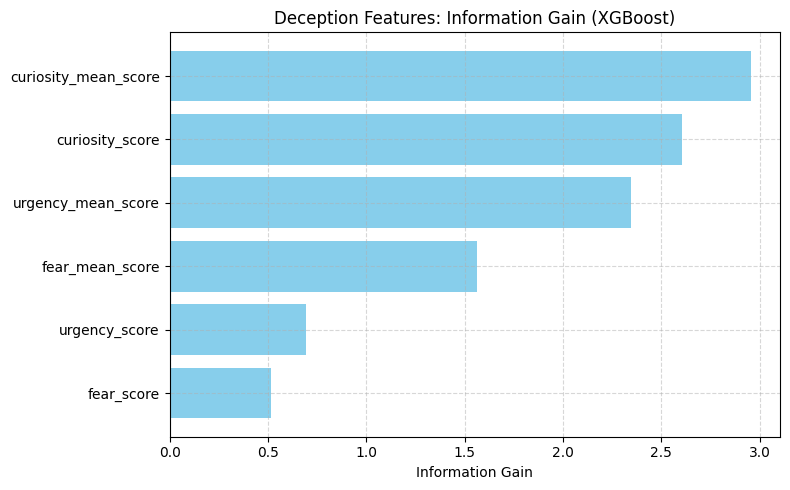

In [ ]:
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type="gain")

# Print out importance of deception features
for feat in feature_names:
    if "score" in feat:
        print(f"{feat}: {importance_dict.get(feat, 0)}")

# Extract only deception features with non-zero importance
deception_features = [f for f in feature_names if "score" in f]
deception_importance = {f: importance_dict.get(f, 0) for f in deception_features}
df_importance = (
    pd.DataFrame.from_dict(
        deception_importance, orient="index", columns=["Information Gain"]
    )
    .reset_index()
    .rename(columns={"index": "Feature"})
    .sort_values(by="Information Gain", ascending=False)
)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(df_importance["Feature"], df_importance["Information Gain"], color="skyblue")
plt.xlabel("Information Gain")
plt.title("Deception Features: Information Gain (XGBoost)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


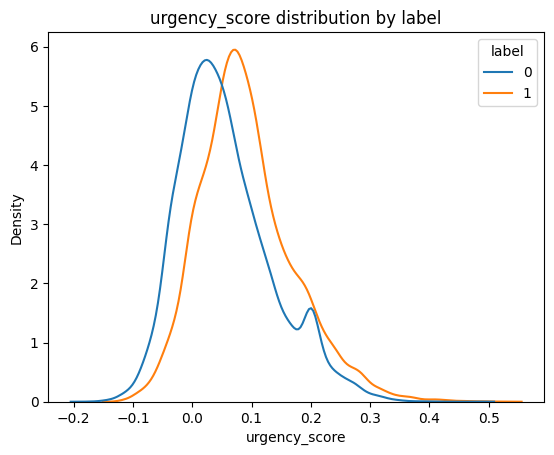

/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


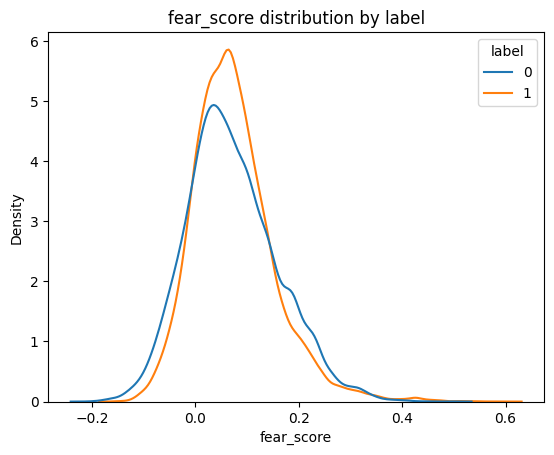

/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


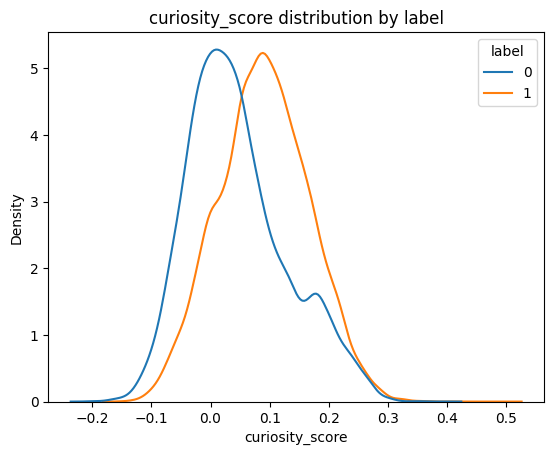

In [ ]:
for col in deception_cols:
    sns.kdeplot(data=df, x=col, hue="label", common_norm=False)
    plt.title(f"{col} distribution by label")
    plt.show()

### Naive:

In [ ]:
# TF-IDF for clean text
tfidf = TfidfVectorizer(max_features=1000)
X_text_tfidf = tfidf.fit_transform(df["clean_text"])

# Deception features (assumes they’re already in the DataFrame)
deception_cols = [
    col for col in df.columns if col.endswith("_score") or col.endswith("_mean_score")
]
X_deception = csr_matrix(df[deception_cols].values)

# Scale deception features between 0 and 1
scaler = MinMaxScaler()
X_deception_scaled = csr_matrix(scaler.fit_transform(df[deception_cols]))

# Combine with TF-IDF
X_combined = hstack([X_text_tfidf, X_deception_scaled])

In [ ]:
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

✅ Naive Bayes (with deception) Accuracy: 0.9596888931044295

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      4926
           1       0.95      0.97      0.96      5617

    accuracy                           0.96     10543
   macro avg       0.96      0.96      0.96     10543
weighted avg       0.96      0.96      0.96     10543



<Figure size 600x500 with 0 Axes>

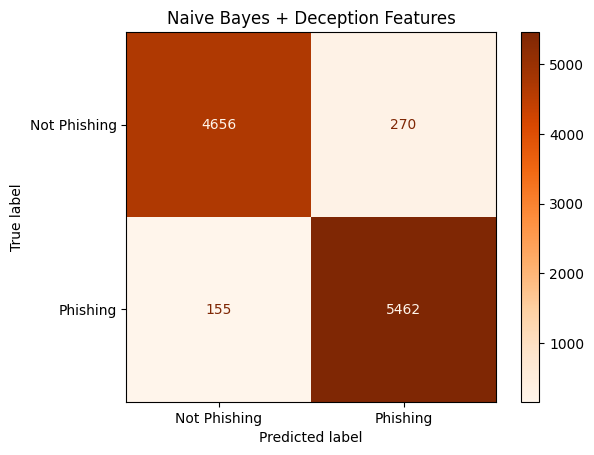

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Evaluate
print("✅ Naive Bayes (with deception) Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"]
)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Oranges, values_format="d")
plt.title("Naive Bayes + Deception Features")
plt.grid(False)
plt.show()